In [1]:
#Importing Stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [3]:
#Reading the data
train=pd.read_csv('train.csv',index_col='id')
test=pd.read_csv('test.csv',index_col='id')
y=train['target']

In [4]:
#Dropping these columns to focus only on the actual tweets
train.drop(['location','keyword'],inplace=True,axis=1)
test.drop(['location','keyword'],inplace=True,axis=1)

In [5]:
#Extracting all the words from the tweets in the Training Data
def create_corpus(train):
    corpus=[]
    num_words = 0

    for i in range(len(train)):
        for j in range(len(train.iloc[i,0].split())):
            corpus.append(train.iloc[i,0].split()[j])
    return corpus
len(create_corpus(train))

113461

In [6]:
#Creating a Dict for counting the number of times each word occurs

def word_count(corpus):
    wcount=defaultdict(int)
    for i in corpus:
        wcount[i]+=1
    return wcount
        
words = word_count(create_corpus(train))

#Creating function to return 10 most used words
def most_used(x):
    return sorted(words.items(),key=lambda kv: kv[1],reverse=True)[:10]

top=most_used(words)
top

[('the', 2575),
 ('a', 1845),
 ('to', 1805),
 ('in', 1757),
 ('of', 1722),
 ('and', 1302),
 ('I', 1197),
 ('for', 820),
 ('is', 814),
 ('on', 773)]

<BarContainer object of 10 artists>

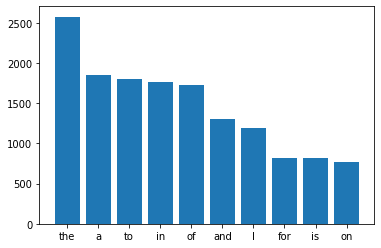

In [7]:
#Visualising the most used words in the training dataset
a,b=zip(*top)
plt.bar(a,b)

In [8]:
print(train['text'].nunique(),train['text'].count())  #Some tweets are identical

7503 7613


In [9]:
duplicate = train[train.duplicated('text',keep = False)] 
duplicate #Shows all tweets that are repeated atleast twice

,text,target
id,,
59,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
68,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
156,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
165,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
171,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...
10855,Evacuation order lifted for town of Roosevelt:...,1
10867,#stormchase Violent Record Breaking EF-5 El Re...,1
10870,@aria_ahrary @TheTawniest The out of control w...,1


In [10]:
duplicate2 = train[train.duplicated(keep=False)]
duplicate2#Shows tweets that have same targets

,text,target
id,,
59,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
68,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
156,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
165,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
171,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...
10855,Evacuation order lifted for town of Roosevelt:...,1
10867,#stormchase Violent Record Breaking EF-5 El Re...,1
10870,@aria_ahrary @TheTawniest The out of control w...,1


In [11]:
#After comparing above two results we can say some tweets despite having same content they have multiple targets 
#this returns all the multiple target tweets
duplicate[~duplicate.isin(duplicate2)].dropna()

,text,target
id,,
1723,Mmmmmm I'm burning.... I'm burning buildings I...,1.0
1752,I Pledge Allegiance To The P.O.P.E. And The Bu...,0.0
1760,like for the music video I want some real acti...,1.0
1922,Mmmmmm I'm burning.... I'm burning buildings I...,0.0
1950,like for the music video I want some real acti...,0.0
1968,I Pledge Allegiance To The P.O.P.E. And The Bu...,1.0
4076,.POTUS #StrategicPatience is a strategy for #G...,0.0
5662,Who is bringing the tornadoes and floods. Who ...,1.0
6012,Caution: breathing may be hazardous to your he...,1.0


In [12]:
#We need to manually rectify these mistakes as we cannot do anything else

train.loc[train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
train.loc[train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
train.loc[train['text'] == 'To fight bioterrorism sir.', 'target'] = 0
train.loc[train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
train.loc[train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
train.loc[train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
train.loc[train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
train.loc[train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
train.loc[train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
train.loc[train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
train.loc[train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
train.loc[train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
train.loc[train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
train.loc[train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
train.loc[train['text'] == "Caution: breathing may be hazardous to your health.", 'target'] = 1
train.loc[train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
train.loc[train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
train.loc[train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

In [13]:
duplicate = train[train.duplicated('text',keep = False)]
duplicate2 = train[train.duplicated(keep=False)]
duplicate[~duplicate.isin(duplicate2)].dropna() #this will return empty dataframe now as we corrected all the labels

,text,target
id,,


In [15]:
#Start Cleanong the Data as there are lots of hashtags and urls and mistakes in  the texts
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] # take max of 2 consecutive letters

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text']=train['text'].apply(lambda x : remove_url(x))
train['text']=train['text'].apply(lambda x : remove_punct(x))
train['text']=train['text'].apply(lambda x : remove_emoji(x))
train['text']=train['text'].apply(lambda x : decontraction(x))
train['text']=train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text']=train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text']=test['text'].apply(lambda x : remove_url(x))
test['text']=test['text'].apply(lambda x : remove_punct(x))
test['text']=test['text'].apply(lambda x : remove_emoji(x))
test['text']=test['text'].apply(lambda x : decontraction(x))
test['text']=test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text']=test['text'].apply(lambda x : unique_char(cont_rep_char,x))

In [16]:
X=train.append(test)
corpus=create_corpus(X)
len(corpus)

155968

In [17]:
train_sentences=[]
for i in range(len(train)):
    train_sentences.append(train.iloc[i,0])
test_sentences=[]
for i in range(len(test)):
    test_sentences.append(test.iloc[i,0])

In [18]:
embedding_dim = 100
oov_tok = "<OOV>"
trunc_type='post'
padding_type='post'
max_length=120

In [19]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

word_index = tokenizer.word_index
vocab_size=len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [20]:
embeddings_index = {};
with open('glove.6B.100d.txt',encoding = "utf-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [33]:
train_padded = np.array(train_padded)
y=np.array(y)
test_padded = np.array(test_padded)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 100)          2201400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 120, 64)           34048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 120, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 116, 32)           10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 38, 64)            16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 38, 64)           

In [36]:
model.fit(train_padded, y, epochs=20)

Epoch 1/10
238/238 [==============================] - 11s 47ms/step - loss: 0.3091 - accuracy: 0.8744
Epoch 2/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2933 - accuracy: 0.8782
Epoch 3/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2757 - accuracy: 0.8853
Epoch 4/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2689 - accuracy: 0.8878
Epoch 5/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2508 - accuracy: 0.8983
Epoch 6/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2454 - accuracy: 0.8989
Epoch 7/10
238/238 [==============================] - 12s 52ms/step - loss: 0.2294 - accuracy: 0.9057
Epoch 8/10
238/238 [==============================] - 12s 50ms/step - loss: 0.2129 - accuracy: 0.9155
Epoch 9/10
238/238 [==============================] - 12s 51ms/step - loss: 0.2061 - accuracy: 0.9183
Epoch 10/10
238/238 [==============================] - 12s 51ms/step - loss: 0.193

In [67]:
result=model.predict(test_padded)
result=np.rint(result)
result=result.astype('int16')
result

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=int16)

In [68]:
res=pd.read_csv('sample_submission.csv',index_col=None)  #Creating a submission file
res['target']=result
res.to_csv('submission.csv',index=False)